In [1]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [26]:
nba_stats2021 = pd.read_csv('./nba_stats2021_original.csv')
nba_stats2021.head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%FTA,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS
0,Stephen Curry,GSW,33,58,32,26,34.1,31.5,10.3,21.3,...,37.9,8.0,17.9,27.6,29.8,20.8,32.5,12.1,32.1,37.1
1,Bradley Beal,WAS,27,57,29,28,35.6,31.1,11.1,22.8,...,37.0,15.9,14.3,22.9,29.6,20.1,26.5,14.3,32.3,34.9
2,Joel Embiid,PHI,27,47,36,11,31.5,29.1,9.2,18.0,...,58.3,43.3,37.2,18.4,34.7,16.1,35.0,21.5,53.0,37.1
3,Luka Doncic,DAL,22,59,35,24,35.1,28.5,10.1,20.8,...,45.4,12.5,25.6,52.4,49.9,21.3,32.2,16.8,38.5,33.7
4,Damian Lillard,POR,30,61,34,27,35.7,28.4,8.8,20.0,...,43.6,6.0,12.8,46.2,36.6,18.0,29.1,11.5,43.1,32.0


In [27]:
# List of Traditional/Boxscore Stats
trad_list = ['MIN','FGM','FGA','FG%','3PM','3PA','3P%','FTM','FTA','FT%','OREB','DREB_x','REB','AST','STL_x','BLK_x','PF','PTS','+/-']

In [28]:
X = nba_stats2021[trad_list]
y = nba_stats2021['Player']

#scale data
nn = Normalizer()
X_nn = nn.fit_transform(X)

#dimensionality reduction
pca = PCA(n_components = 5)
pca.fit(X_nn)
X_pca = pca.transform(X_nn)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

#creating clusters
trad = KMeans(n_clusters = 4, random_state= 42)
trad.fit(X_pca)
y_kmeans = trad.predict(X_pca)
nba_stats2021['trad_kmean'] = trad.labels_
trad_sil = silhouette_score(X_nn, trad.labels_)
print("Silhouette Score:", silhouette_score(X_nn, trad.labels_))

Cumulative Explained Variance: 0.9735292282433772
Silhouette Score: 0.4741750961794488


In [29]:
trad_cluster0 = nba_stats2021[nba_stats2021['trad_kmean']==0]
trad_cluster1 = nba_stats2021[nba_stats2021['trad_kmean']==1]
trad_cluster2 = nba_stats2021[nba_stats2021['trad_kmean']==2]
trad_cluster3 = nba_stats2021[nba_stats2021['trad_kmean']==3]

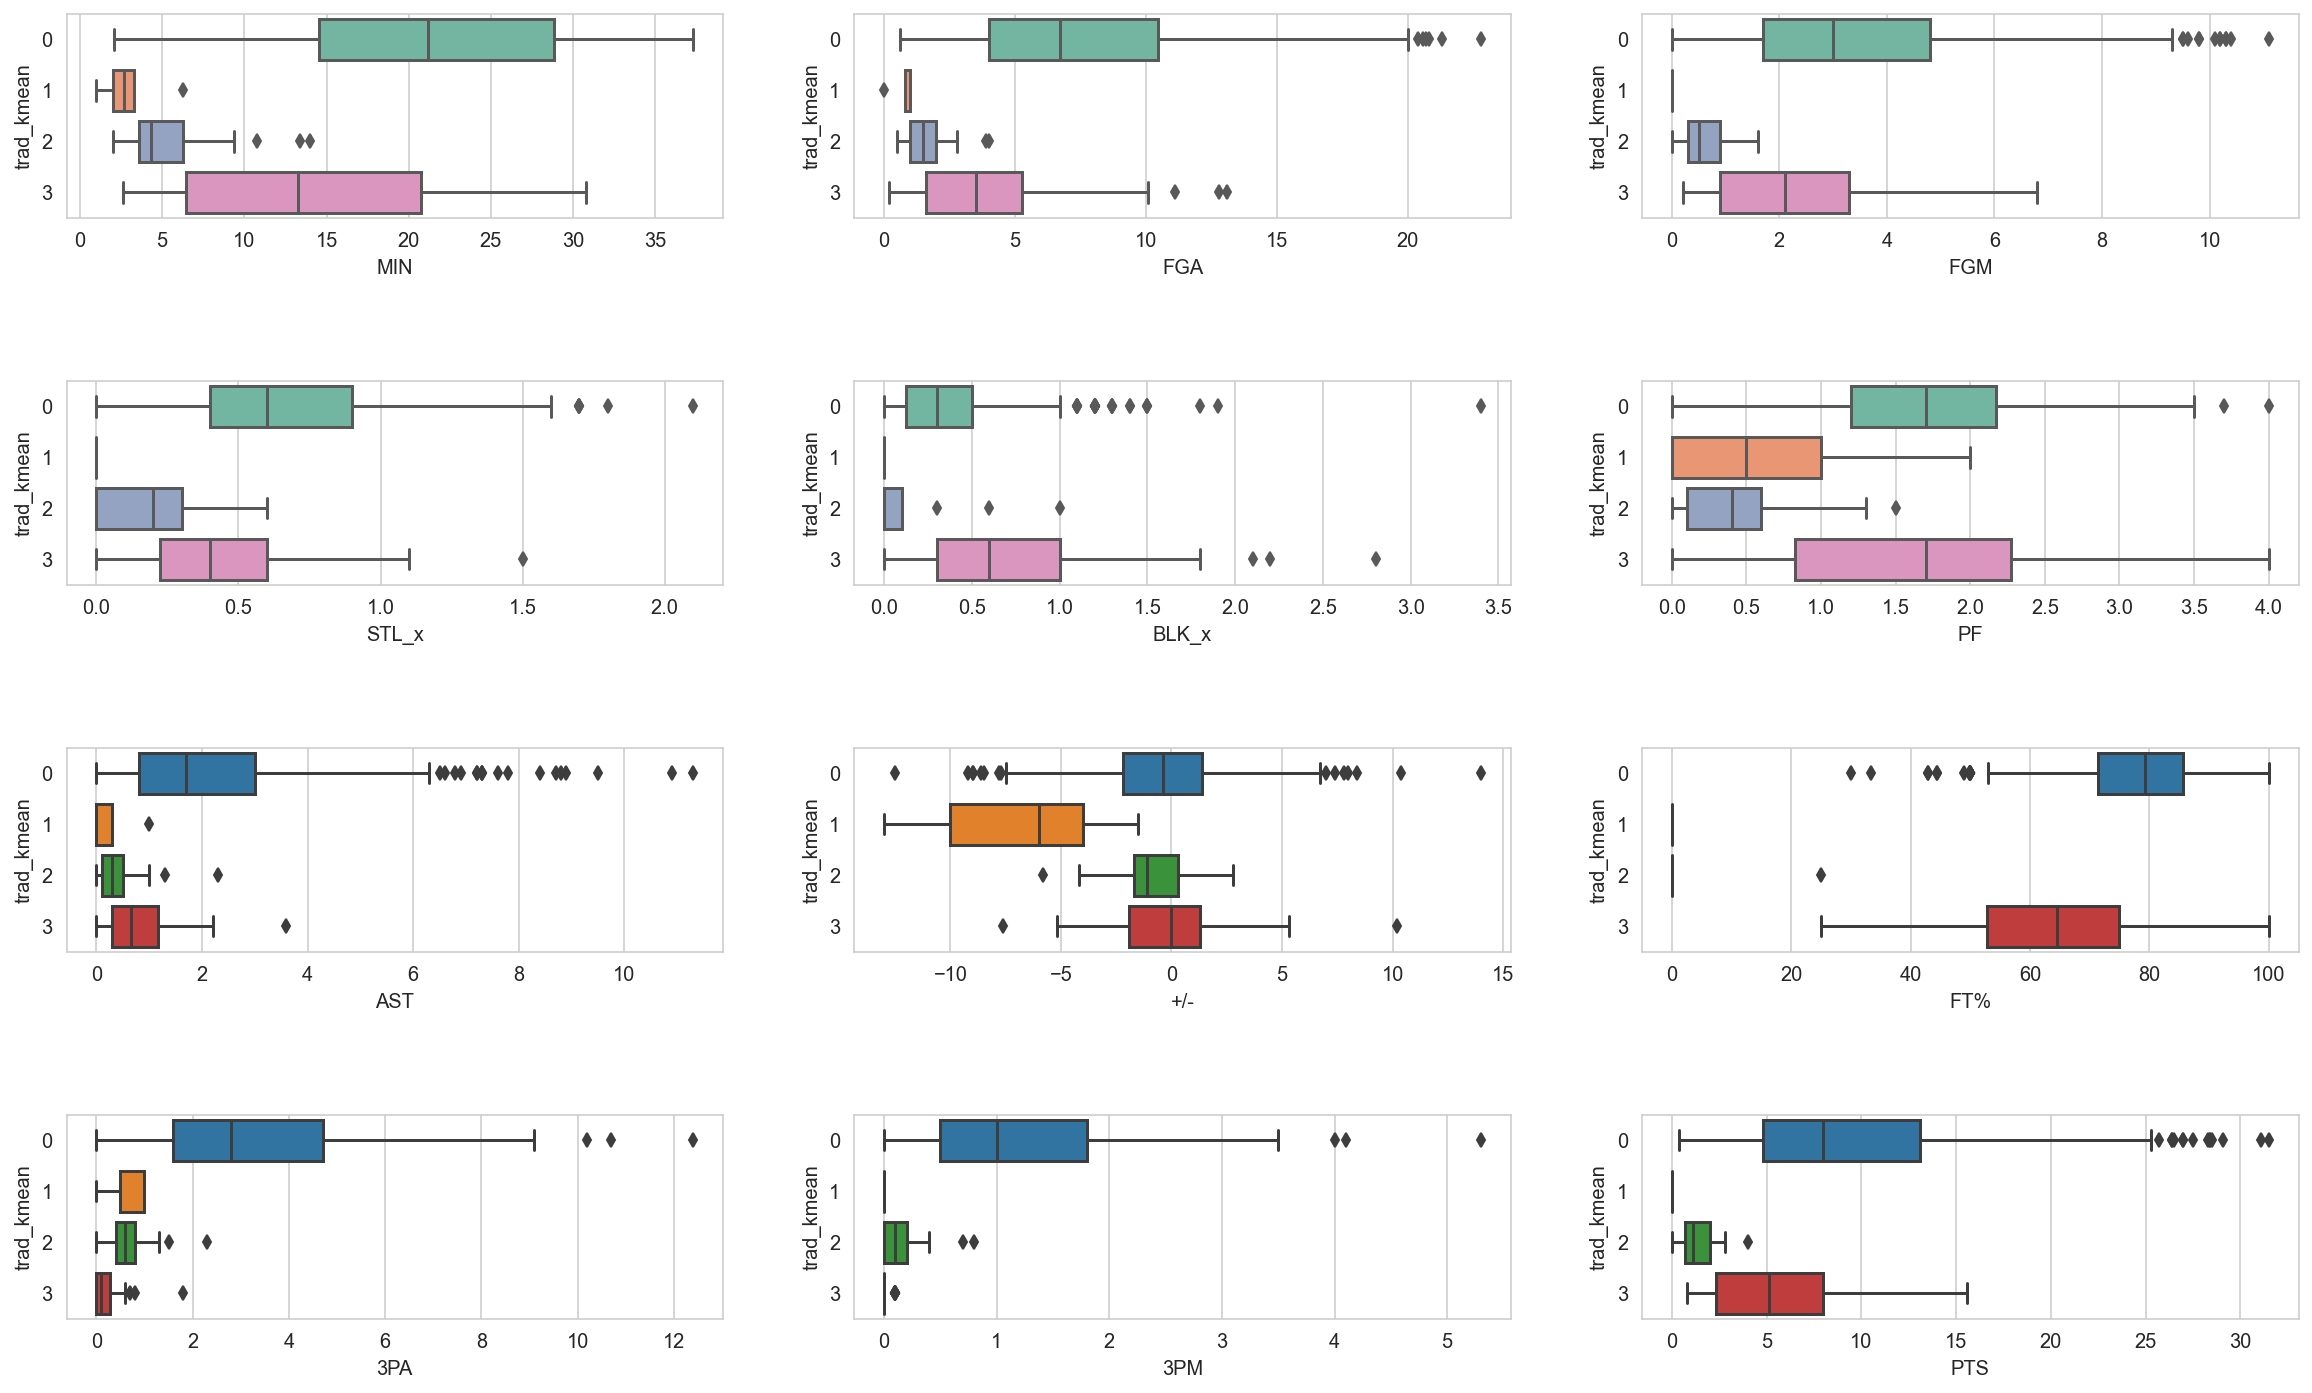

In [30]:
fig, axes = plt.subplots(4, 3, figsize = (20, 12))
plt.subplots_adjust(hspace = 0.8)

# How well a player impacts the game (scorer)
sns.boxplot(x = 'MIN', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,0])
sns.boxplot(x = 'FGA', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,1])
sns.boxplot(x = 'FGM', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,2])
#---------------------- line 2
# How well a player defends the opposing teams best player (floor general)
sns.boxplot(x = 'STL_x', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,0])
sns.boxplot(x = 'BLK_x', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,1])
sns.boxplot(x = 'PF', y = 'trad_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,2])
#---------------------- LINE 3
# How well a player scores 2 pointers off passes
sns.boxplot(x = 'AST', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[2,0])
sns.boxplot(x = '+/-', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[2,1])
sns.boxplot(x = 'FT%', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[2,2])
#---------------------- LINE 4
# How well a player can score the 3 pointer
sns.boxplot(x = '3PA', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[3,0])
sns.boxplot(x = '3PM', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[3,1])
sns.boxplot(x = 'PTS', y = 'trad_kmean', data = nba_stats2021, orient="h", ax = axes[3,2]);

## ```Recommender Dataframes```
---

In [9]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

In [12]:
# Creating Pivot table
trad_piv = pd.pivot_table(nba_stats2021[trad_list], index = nba_stats2021['Player'])

# Create sparse matrix
trad_sparse = sparse.csr_matrix(trad_piv.fillna(0))

# Calculating Cosine similarity
trad_recommend = pairwise_distances(trad_sparse, metric='cosine')

# Creating Recommender Dataframe
trad_rec_df = pd.DataFrame(trad_recommend, columns=trad_piv.index, index = trad_piv.index)

In [13]:
pickle.dump(trad_rec_df, open('pickle models/trad_stat.p', 'wb'))

In [21]:
players = trad_rec_df['LeBron James'].sort_values()[1:10].index
players

Index(['Luka Doncic', 'Nikola Jokic', 'Jaylen Brown', 'Giannis Antetokounmpo',
       'Kevin Durant', 'Julius Randle', 'Kawhi Leonard', 'Zach LaVine',
       'Anthony Davis'],
      dtype='object', name='Player')

## ```Modern Player Reclassification```
---

In [33]:
trad_cluster0.sort_values(by='%PTS', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean
0,Stephen Curry,GSW,33,58,32,26,34.1,31.5,10.3,21.3,...,8.0,17.9,27.6,29.8,20.8,32.5,12.1,32.1,37.1,0
2,Joel Embiid,PHI,27,47,36,11,31.5,29.1,9.2,18.0,...,43.3,37.2,18.4,34.7,16.1,35.0,21.5,53.0,37.1,0
1,Bradley Beal,WAS,27,57,29,28,35.6,31.1,11.1,22.8,...,15.9,14.3,22.9,29.6,20.1,26.5,14.3,32.3,34.9,0
5,Giannis Antetokounmpo,MIL,26,56,36,20,33.1,28.4,10.3,18.3,...,24.9,33.5,33.2,37.3,21.1,35.1,23.3,55.8,34.0,0
3,Luka Doncic,DAL,22,59,35,24,35.1,28.5,10.1,20.8,...,12.5,25.6,52.4,49.9,21.3,32.2,16.8,38.5,33.7,0


In [37]:
trad_cluster1.sort_values(by='%BLKA', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean
532,Noah Vonleh,BKN,25,4,3,1,2.7,0.0,0.0,0.8,...,0.0,16.7,20.0,33.3,0.0,50.0,33.3,0.0,0.0,1
528,Anzejs Pasecniks,WAS,25,1,1,0,6.3,0.0,0.0,1.0,...,50.0,20.0,33.3,100.0,0.0,0.0,50.0,0.0,0.0,1
529,Ashton Hagans,MIN,21,2,0,2,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,1
531,Louis King,SAC,22,1,1,0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
533,Will Magnay,NOP,22,1,1,0,3.3,0.0,0.0,1.0,...,0.0,0.0,0.0,25.0,0.0,0.0,50.0,0.0,0.0,1


In [38]:
trad_cluster1['+/-'].mean()

-6.9

In [41]:
trad_cluster2.sort_values(by='MIN', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean
396,Jordan Bone,ORL,23,14,2,12,14.0,4.0,1.6,3.9,...,9.5,13.3,22.5,5.3,9.5,0.0,17.2,3.9,13.8,2
436,Jordan Bell,WAS,26,5,2,3,13.4,2.8,1.4,4.0,...,33.3,30.6,17.9,20.0,27.3,30.0,20.8,14.3,11.1,2
492,Tim Frazier,MEM,30,3,3,0,10.8,1.3,0.7,2.7,...,0.0,12.1,38.9,25.0,11.1,25.0,30.8,0.0,6.5,2
473,Ray Spalding,HOU,24,2,0,2,9.4,2.0,1.0,2.0,...,28.6,18.2,0.0,37.5,0.0,0.0,50.0,14.3,10.0,2
521,Jared Dudley,LAL,35,11,6,5,6.9,0.5,0.2,0.6,...,18.2,23.2,19.2,7.7,8.3,10.0,26.9,0.0,3.7,2


In [45]:
trad_cluster3.sort_values(by='+/-', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean
94,Rudy Gobert,UTA,28,65,48,17,30.8,14.4,5.5,8.2,...,51.4,42.2,8.1,19.1,13.9,26.9,21.5,36.8,18.9,3
304,Nicolas Claxton,BKN,22,26,18,8,18.0,6.3,2.7,4.6,...,37.2,29.0,10.7,11.1,23.5,16.7,26.2,18.9,14.3,3
232,Dewayne Dedmon,MIA,31,11,7,4,13.2,8.1,3.2,4.3,...,59.0,44.8,9.1,32.1,31.8,22.2,35.1,28.8,24.9,3
447,Amida Brimah,IND,27,5,2,3,5.9,2.6,1.0,1.6,...,40.0,23.5,6.3,33.3,0.0,0.0,28.6,25.0,16.9,3
90,Deandre Ayton,PHX,22,66,47,19,30.6,14.5,6.3,10.1,...,57.1,38.8,8.6,18.6,12.9,34.1,25.3,21.7,19.8,3


In [67]:
trad_cluster3['PF'].mean()

1.606060606060606

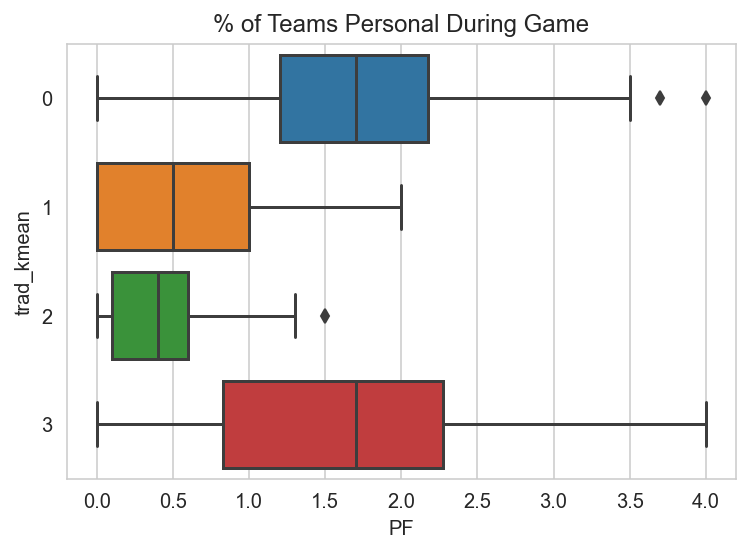

In [69]:
plt.title('% of Teams Personal During Game')
sns.boxplot(x = 'PF', y = 'trad_kmean', data = nba_stats2021, orient="h");

In [56]:
trad_cluster3['MIN'].mean()+trad_cluster3['MIN'].std()*2

31.70424572215307

In [57]:
trad_cluster3['BLK_x'].mean()

0.703030303030303

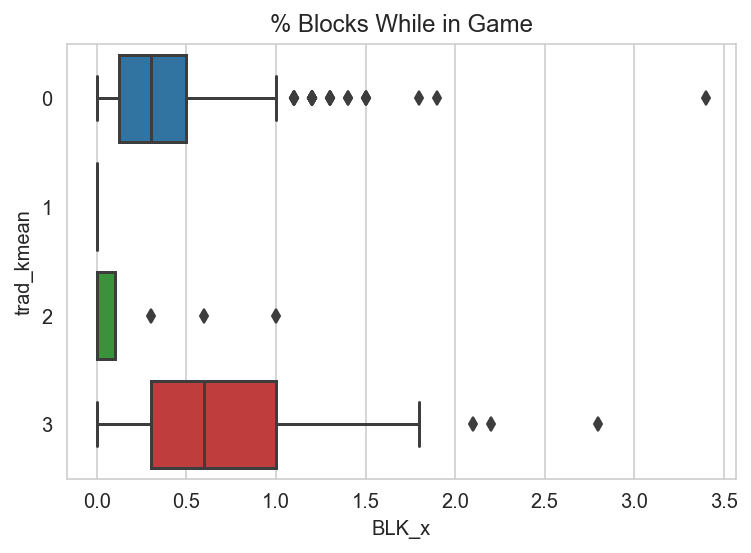

In [66]:
plt.title('% Blocks While in Game')
sns.boxplot(x = 'BLK_x', y = 'trad_kmean', data = nba_stats2021, orient="h");

In [58]:
trad_cluster3['FGM'].mean()

2.331818181818182

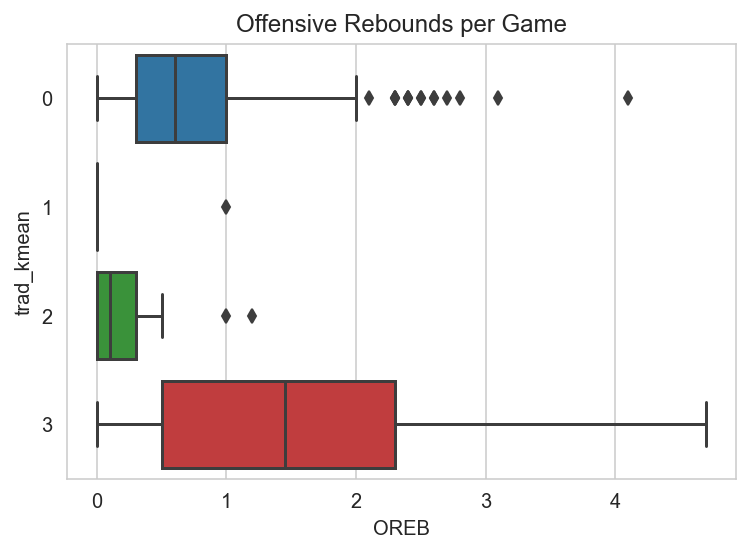

In [64]:
plt.title('Offensive Rebounds per Game')
sns.boxplot(x = 'OREB', y = 'trad_kmean', data = nba_stats2021, orient="h");

In [63]:
trad_cluster3['OREB'].mean()

1.5939393939393935